In [1]:
import os
import torch, dgl

In [20]:
# def load_stat(psize, epoch, bsize=1024, dataset='ogbn-papers100M', dir='stats'):
#     return torch.load(f'{dir}/{dataset}.p{psize}.b{bsize}.e{epoch}.pt')
# nids, degs, accs, losses = load_stat(psize=16,epoch=10)
# sorted_degs, idx = torch.sort(degs)

import sampler
from graphloader import GraphLoader
data = GraphLoader(name='ogbn_arxiv', root=f"{os.environ['DATASETS']}/baseline", mmap=True)
g = data.graph

train_nids = g.nodes()[g.ndata['train_mask']]
train_degs = g.out_degrees(train_nids)
print('#edges incident on training nodes:', train_degs.sum())
assigns = sampler.rand_partition_assignment(g, 128)
cuts = sampler.train_edge_cuts_from(g, assigns, 128)
print('#train_cuts sum:', cuts.long().sum())

#edges incident on training nodes: tensor(1312984)
#train_cuts sum: tensor(1312984)


In [7]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 128

def metis_heatmap(g, psize, zero_diag=True, train_cuts=True):
    assigns = sampler.metis_partition_assignment(g, psize, g.ndata['train_mask'])
    if train_cuts:
        cuts = sampler.train_edge_cuts_from(g, assigns, psize)
    else:
        cuts = sampler.edge_cuts_from(g, assigns, psize)
    print(cuts.shape)
    if zero_diag:
        cuts.fill_diagonal_(0)
    plt.figure()
    plt.pcolor(torch.arange(psize), torch.arange(psize), cuts, cmap='hot')
    plt.gca().invert_yaxis()
    plt.title(f'ogbn-arxiv, METIS, psize={psize}, train_cuts={train_cuts}')
    plt.colorbar()
    plt.savefig(f'figs/arxiv_METIS_{psize}{"_nodiag" if zero_diag else ""}{"_train" if train_cuts else ""}.png', dpi=128)
    plt.show()
    
def rand_heatmap(g, psize, zero_diag=True, train_cuts=True):
    assigns = sampler.rand_partition_assignment(g, psize)
    if train_cuts:
        cuts = sampler.train_edge_cuts_from(g, assigns, psize)
    else:
        cuts = sampler.edge_cuts_from(g, assigns, psize)
    print(cuts.shape)
    if zero_diag:
        cuts.fill_diagonal_(0)
    plt.figure()
    plt.pcolor(torch.arange(psize), torch.arange(psize), cuts, cmap='hot')
    plt.gca().invert_yaxis()
    plt.title(f'ogbn-arxiv, RAND, psize={psize}, train_cuts={train_cuts}')
    plt.colorbar()
    plt.savefig(f'figs/arxiv_RAND_{psize}{"_nodiag" if zero_diag else ""}{"_train" if train_cuts else ""}.png', dpi=128)
    plt.show()

    def 

Convert a graph into a bidirected graph: 0.052 seconds, peak memory: 33.321 GB
Construct multi-constraint weights: 0.005 seconds, peak memory: 33.321 GB


[12:51:58] /home/tianhaoh/proj/dgl/src/graph/transform/metis_partition_hetero.cc:87: Partition a graph with 169343 nodes and 2315598 edges into 128 parts and get 577700 edge cuts


Metis partitioning: 1.282 seconds, peak memory: 33.431 GB
torch.Size([128, 128])


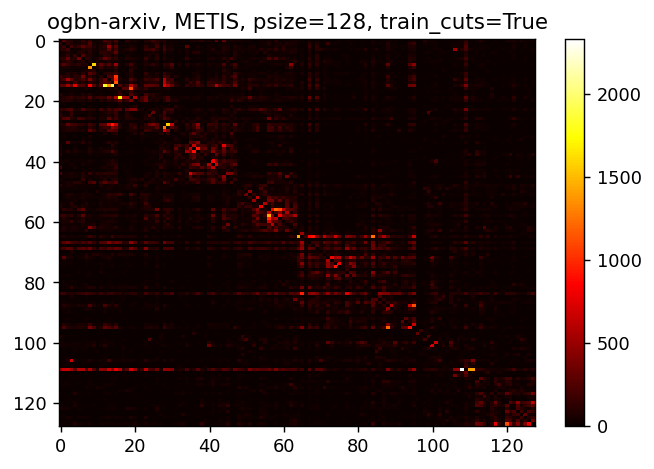

In [8]:
metis_heatmap(g, 128)

torch.Size([128, 128])


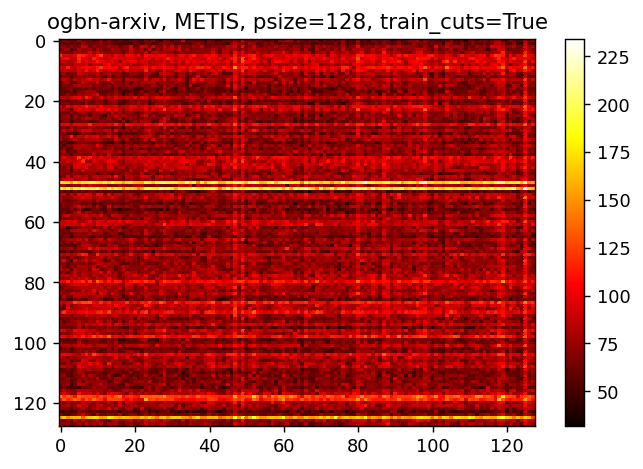

In [6]:
rand_heatmap(g, 128, zero_diag=False)

Convert a graph into a bidirected graph: 0.056 seconds, peak memory: 33.431 GB
Construct multi-constraint weights: 0.004 seconds, peak memory: 33.431 GB


[12:58:13] /home/tianhaoh/proj/dgl/src/graph/transform/metis_partition_hetero.cc:87: Partition a graph with 169343 nodes and 2315598 edges into 128 parts and get 577700 edge cuts


Metis partitioning: 1.290 seconds, peak memory: 33.431 GB
torch.Size([128, 128])


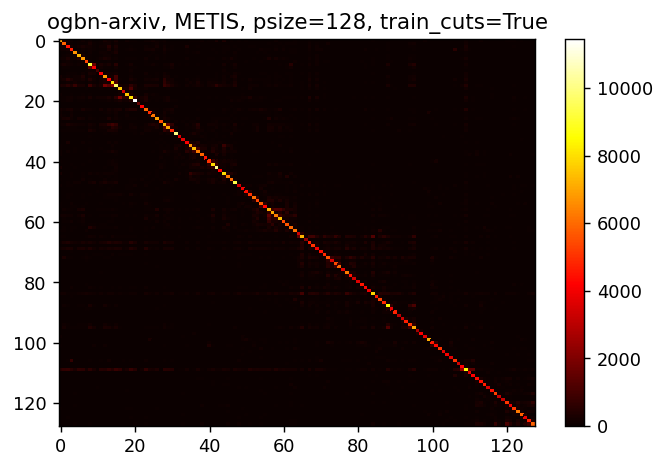

In [11]:
metis_heatmap(g, 128, zero_diag=False)

Convert a graph into a bidirected graph: 0.053 seconds, peak memory: 33.431 GB
Construct multi-constraint weights: 0.005 seconds, peak memory: 33.431 GB


[13:02:02] /home/tianhaoh/proj/dgl/src/graph/transform/metis_partition_hetero.cc:87: Partition a graph with 169343 nodes and 2315598 edges into 512 parts and get 738332 edge cuts


Metis partitioning: 2.478 seconds, peak memory: 33.444 GB
torch.Size([512, 512])


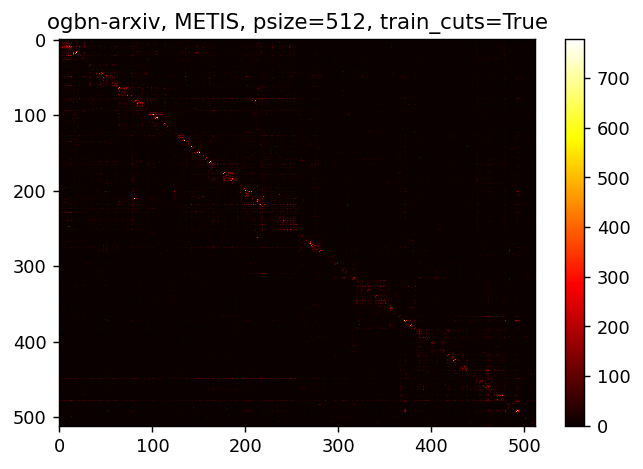

In [12]:
metis_heatmap(g, 512)

In [66]:
def rows_weight(cuts: torch.Tensor, rows: torch.Tensor, zero_diag=True, new_fig=True, label=None) -> torch.Tensor:
    if zero_diag:
        cuts = cuts.clone()
        cuts.fill_diagonal_(0)
    psize = cuts.shape[0]
    rows = rows.unique()
    weight_sum = cuts[rows].sum(dim=0)
    if new_fig:
        plt.figure()
    plt.plot(torch.arange(psize), weight_sum, label=label)
    return weight_sum

In [96]:
psize=128
assigns = sampler.rand_partition_assignment(g, psize)
cuts = sampler.train_edge_cuts_from(g, assigns, psize)

metis_assigns = sampler.metis_partition_assignment(g, psize, g.ndata['train_mask'])
metis_cuts = sampler.train_edge_cuts_from(g, metis_assigns, psize)

Convert a graph into a bidirected graph: 0.052 seconds, peak memory: 67.850 GB
Construct multi-constraint weights: 0.004 seconds, peak memory: 67.850 GB
Metis partitioning: 1.290 seconds, peak memory: 67.865 GB


[14:40:34] /home/tianhaoh/proj/dgl/src/graph/transform/metis_partition_hetero.cc:87: Partition a graph with 169343 nodes and 2315598 edges into 128 parts and get 577700 edge cuts


METIS: std-mean = (tensor(1009.8271), tensor(2050.9062))
RAND: std-mean = (tensor(301.1686), tensor(4032.6172))


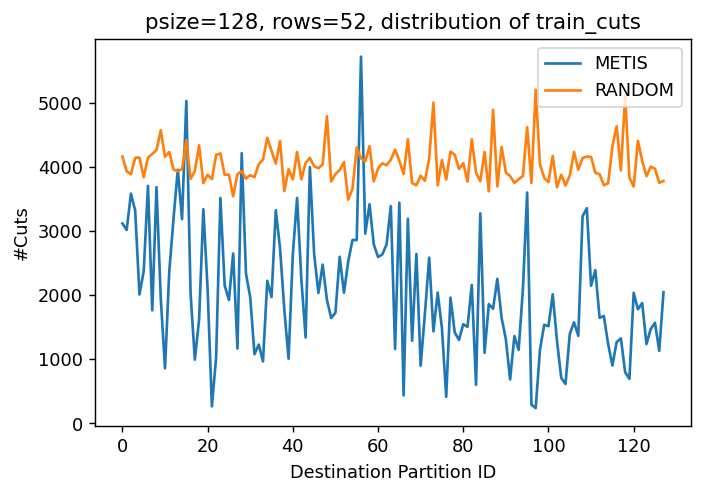

In [102]:
rows=torch.randint(psize, (psize//2,)).unique()
# rows = torch.arange(psize)
nrows=rows.shape[0]
metis_weights = rows_weight(metis_cuts, rows, label="METIS")
rand_weights = rows_weight(cuts, rows, new_fig=False, label="RANDOM")
plt.title(f"psize={psize}, rows={nrows}, distribution of train_cuts")
plt.xlabel("Destination Partition ID")
plt.ylabel("#Cuts")
plt.legend()
print("METIS: std-mean =", torch.std_mean(metis_weights))
print("RAND: std-mean =", torch.std_mean(rand_weights))
plt.savefig(f"figs/arxiv_row_weights_{psize}_{nrows}.png", dpi=128)